### Collaborative Filtering: From Neighbors to Latent Factors
==========================================================

This notebook implements and analyzes collaborative filtering methods:
- User-based CF with different similarity metrics
- Item-based CF 
- Matrix Factorization (SVD)
- Alternating Least Squares (ALS)
- Hyperparameter tuning
- Detailed comparison and analysis

In [ ]:
# ============================================================================
# 1: Imports and Setup
# ============================================================================
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import time
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import MovieLensLoader
from src.preprocess import prepare_data_for_training
from src.recommenders.collaborative import (
    UserBasedCF,
    ItemBasedCF,
    MatrixFactorizationSVD,
    AlternatingLeastSquares
)
from src.evaluation import RecommenderEvaluator
from src.utils import plot_model_comparison

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")



✓ Imports successful


In [4]:

# ============================================================================
# 2: Load and Prepare Data
# ============================================================================
print("Loading MovieLens data...")
loader = MovieLensLoader()
ratings = loader.load_ratings()
movies = loader.load_movies()

# Prepare data with user-based split (ensures all users in both sets)
print("\nPreparing train/test split...")
train, test, metadata = prepare_data_for_training(
    ratings,
    test_size=0.2,
    split_method='user_based',
    min_user_ratings=10,
    min_item_ratings=5,
    random_state=42
)

all_items = set(ratings['item_id'].unique())

print("\n✓ Data loaded")
print(f"  Train: {len(train):,} ratings")
print(f"  Test: {len(test):,} ratings")
print(f"  Users: {train['user_id'].nunique():,}")
print(f"  Items: {train['item_id'].nunique():,}")
print(f"  Sparsity: {metadata['sparsity']:.4f}")


Loading MovieLens data...
Loaded 100,000 ratings
Users: 943
Items: 1,682
Sparsity: 0.9370
Loaded 1,682 movies

Preparing train/test split...
Data Preparation Pipeline
Filtered: 100,000 -> 99,287 ratings
Users: 943
Items: 1,349
User-based split: 79,790 train, 19,497 test
All 943 users have data in both sets

Data Preparation Complete
Train ratings: 79,790
Test ratings: 19,497
Users: 943
Items: 1,682
Sparsity: 0.9370

✓ Data loaded
  Train: 79,790 ratings
  Test: 19,497 ratings
  Users: 943
  Items: 1,349
  Sparsity: 0.9370



UNDERSTANDING THE USER-ITEM MATRIX


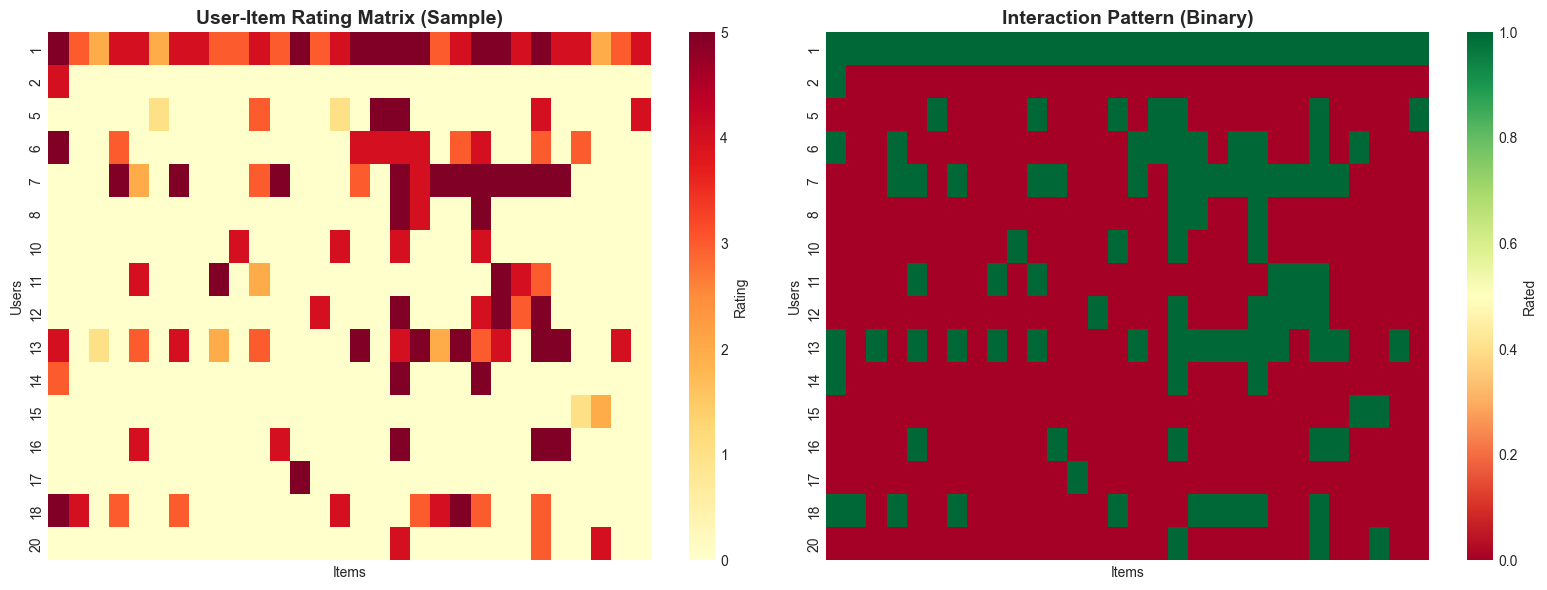


Sample matrix density: 0.2542


In [5]:
# ============================================================================
# 3: Understanding the Data Matrix
# ============================================================================
print("\n" + "="*70)
print("UNDERSTANDING THE USER-ITEM MATRIX")
print("="*70)

# Create sample user-item matrix for visualization
sample_users = train['user_id'].unique()[:20]
sample_items = train['item_id'].unique()[:30]

sample_data = train[
    train['user_id'].isin(sample_users) & 
    train['item_id'].isin(sample_items)
]

sample_matrix = sample_data.pivot_table(
    index='user_id',
    columns='item_id',
    values='rating',
    fill_value=0
)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw ratings
sns.heatmap(
    sample_matrix,
    cmap='YlOrRd',
    cbar_kws={'label': 'Rating'},
    ax=axes[0],
    xticklabels=False,
    yticklabels=True
)
axes[0].set_title('User-Item Rating Matrix (Sample)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Items')
axes[0].set_ylabel('Users')

# Binary (rated/not rated)
sns.heatmap(
    (sample_matrix > 0).astype(int),
    cmap='RdYlGn',
    cbar_kws={'label': 'Rated'},
    ax=axes[1],
    xticklabels=False,
    yticklabels=True
)
axes[1].set_title('Interaction Pattern (Binary)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Items')
axes[1].set_ylabel('Users')

plt.tight_layout()
plt.show()

print(f"\nSample matrix density: {(sample_matrix > 0).sum().sum() / sample_matrix.size:.4f}")



USER-BASED COLLABORATIVE FILTERING

1. Training User-Based CF with Cosine Similarity...
UserBasedCF fitted with k=50, similarity='cosine'
   Training time: 14.33s

Sample prediction (user=1, item=100): 4.60

Top 10 recommendations for User 1:
   1. Hearts and Minds (1996)                            (score: 5.000)
   2. Pather Panchali (1955)                             (score: 4.853)
   3. Star Wars (1977)                                   (score: 4.839)
   4. Usual Suspects, The (1995)                         (score: 4.795)
   5. Wrong Trousers, The (1993)                         (score: 4.762)
   6. Shawshank Redemption, The (1994)                   (score: 4.752)
   7. Godfather, The (1972)                              (score: 4.749)
   8. Close Shave, A (1995)                              (score: 4.700)
   9. Faust (1994)                                       (score: 4.651)
  10. Wallace & Gromit: The Best of Aardman Animation (1 (score: 4.615)

2. Training User-Based CF with Pear

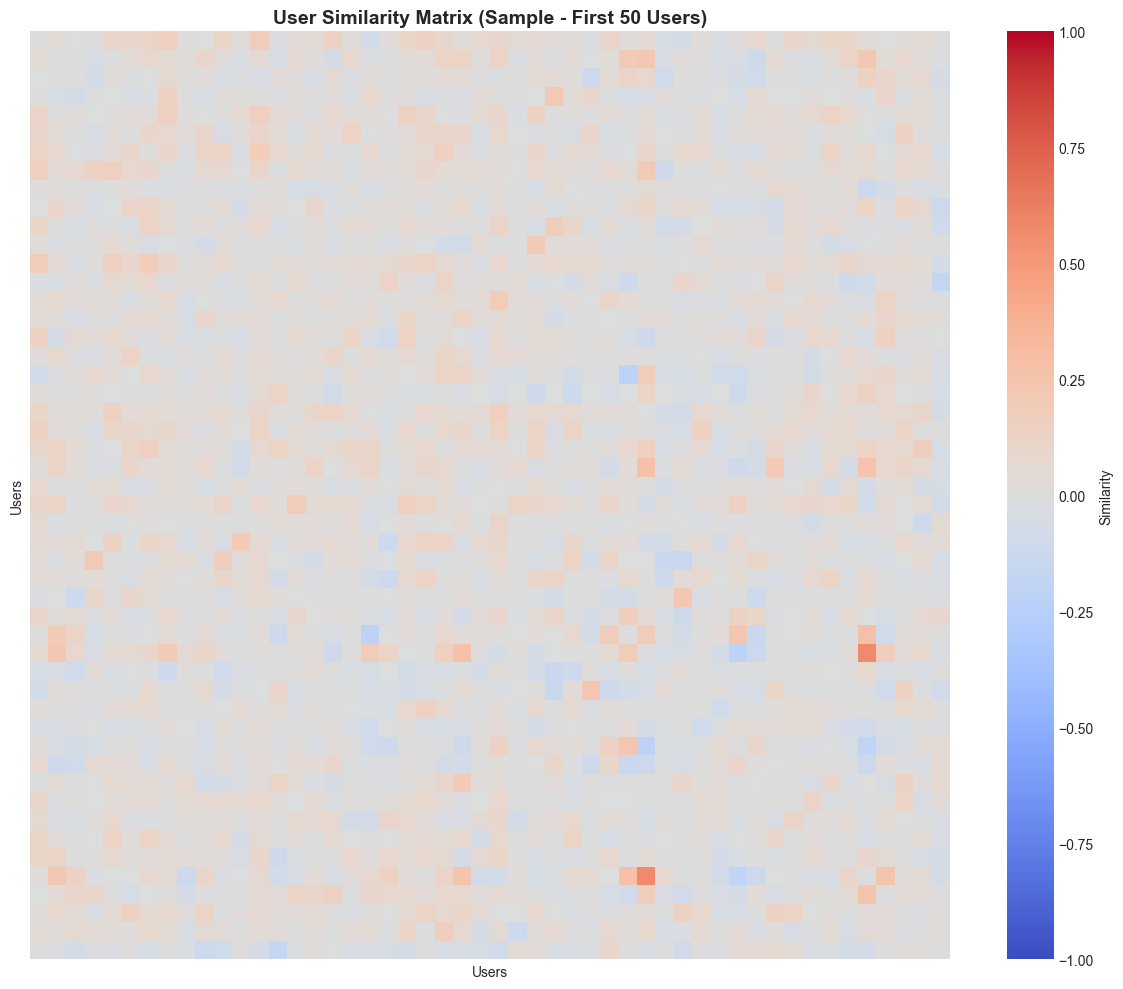

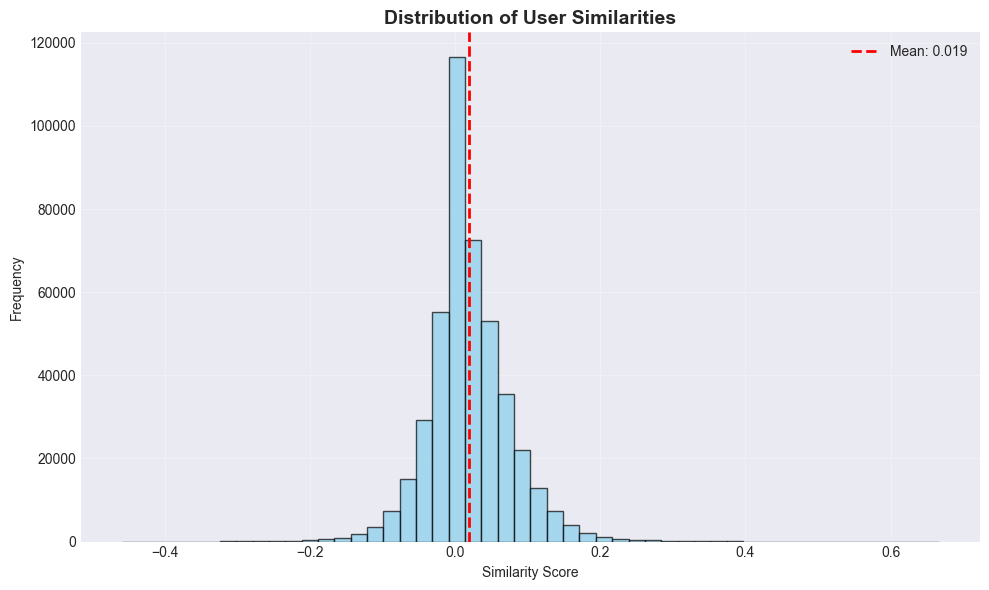


Similarity statistics:
  Mean: 0.0187
  Std: 0.0558
  Min: -0.4593
  Max: 0.6668


In [6]:

# ============================================================================
# 4: User-Based Collaborative Filtering
# ============================================================================
print("\n" + "="*70)
print("USER-BASED COLLABORATIVE FILTERING")
print("="*70)

print("\n1. Training User-Based CF with Cosine Similarity...")
user_cf_cosine = UserBasedCF(k=50, similarity='cosine')
start_time = time.time()
user_cf_cosine.fit(train)
train_time = time.time() - start_time
print(f"   Training time: {train_time:.2f}s")

# Test prediction
pred = user_cf_cosine.predict(user_id=1, item_id=100)
print(f"\nSample prediction (user=1, item=100): {pred:.2f}")

# Generate recommendations
print("\nTop 10 recommendations for User 1:")
recs = user_cf_cosine.recommend(user_id=1, n=10, exclude_seen=True)
for i, (item_id, score) in enumerate(recs, 1):
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"  {i:2d}. {title[:50]:50s} (score: {score:.3f})")

# Compare with Pearson similarity
print("\n2. Training User-Based CF with Pearson Correlation...")
user_cf_pearson = UserBasedCF(k=50, similarity='pearson')
user_cf_pearson.fit(train)

# Visualize user similarity matrix (sample)
print("\n3. User Similarity Analysis")
sample_sim = user_cf_cosine.user_similarity[:50, :50]

plt.figure(figsize=(12, 10))
sns.heatmap(
    sample_sim,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Similarity'},
    xticklabels=False,
    yticklabels=False
)
plt.title('User Similarity Matrix (Sample - First 50 Users)', fontsize=14, fontweight='bold')
plt.xlabel('Users')
plt.ylabel('Users')
plt.tight_layout()
plt.show()

# Analyze similarity distribution
sim_values = user_cf_cosine.user_similarity[np.triu_indices_from(user_cf_cosine.user_similarity, k=1)]
plt.figure(figsize=(10, 6))
plt.hist(sim_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(sim_values.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {sim_values.mean():.3f}')
plt.title('Distribution of User Similarities', fontsize=14, fontweight='bold')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nSimilarity statistics:")
print(f"  Mean: {sim_values.mean():.4f}")
print(f"  Std: {sim_values.std():.4f}")
print(f"  Min: {sim_values.min():.4f}")
print(f"  Max: {sim_values.max():.4f}")



ITEM-BASED COLLABORATIVE FILTERING

1. Training Item-Based CF...
ItemBasedCF fitted with k=50, similarity='cosine'
   Training time: 11.08s

Top 10 recommendations for User 1:
   1. Jean de Florette (1986)                            (score: 4.646)
   2. Horseman on the Roof, The (Hussard sur le toit, Le (score: 4.584)
   3. Kids in the Hall: Brain Candy (1996)               (score: 4.548)
   4. French Twist (Gazon maudit) (1995)                 (score: 4.436)
   5. Kaspar Hauser (1993)                               (score: 4.435)
   6. Chasing Amy (1997)                                 (score: 4.432)
   7. Ridicule (1996)                                    (score: 4.418)
   8. Haunted World of Edward D. Wood Jr., The (1995)    (score: 4.405)
   9. Kansas City (1996)                                 (score: 4.396)
  10. Fargo (1996)                                       (score: 4.353)

2. Similar Items Analysis

Movies similar to 'Toy Story (1995)':
   1. Aladdin (1992)                 

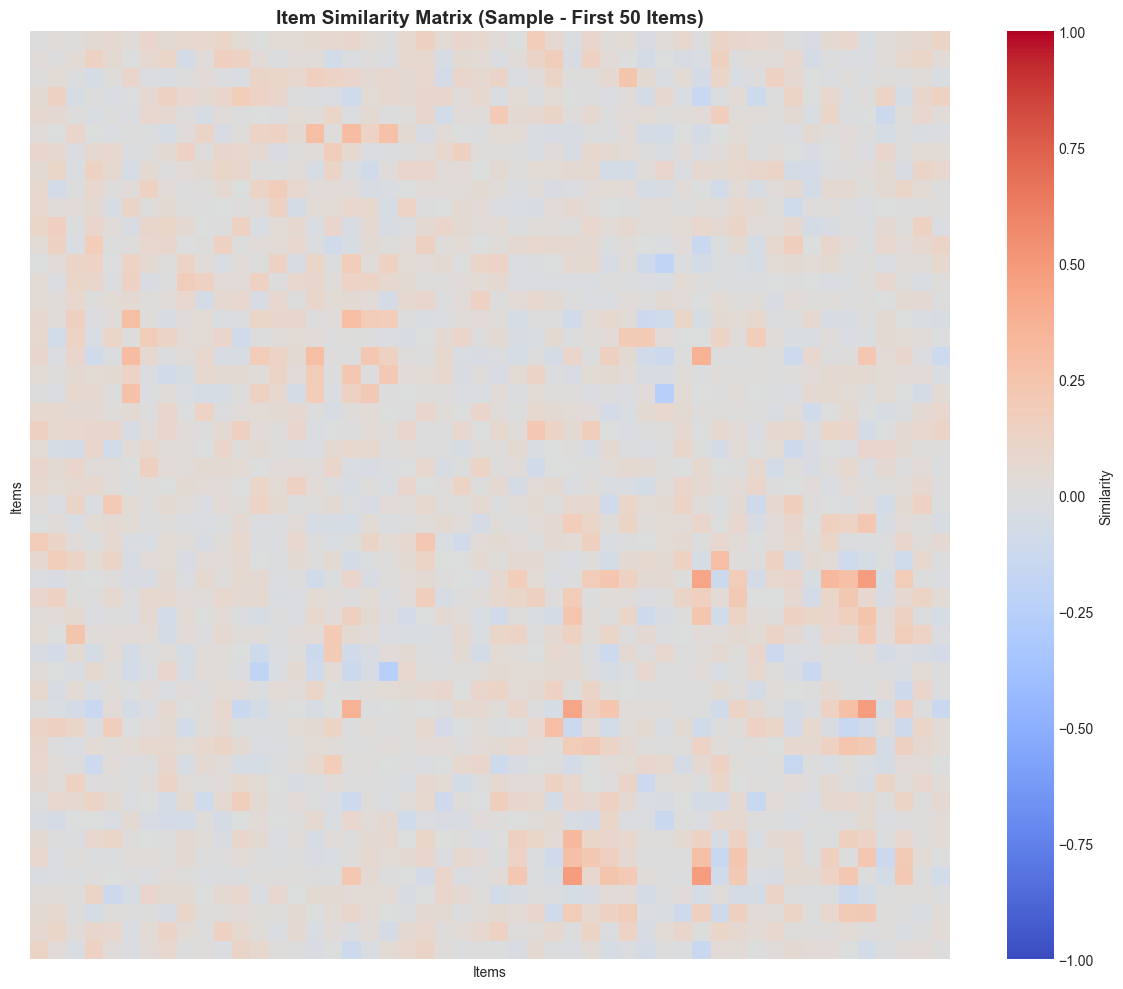

In [7]:
# ============================================================================
# 5: Item-Based Collaborative Filtering
# ============================================================================
print("\n" + "="*70)
print("ITEM-BASED COLLABORATIVE FILTERING")
print("="*70)

print("\n1. Training Item-Based CF...")
item_cf = ItemBasedCF(k=50, similarity='cosine')
start_time = time.time()
item_cf.fit(train)
train_time = time.time() - start_time
print(f"   Training time: {train_time:.2f}s")

# Generate recommendations
print("\nTop 10 recommendations for User 1:")
recs = item_cf.recommend(user_id=1, n=10, exclude_seen=True)
for i, (item_id, score) in enumerate(recs, 1):
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"  {i:2d}. {title[:50]:50s} (score: {score:.3f})")

# Find similar items
print("\n2. Similar Items Analysis")
sample_item = 1  # Toy Story
movie_title = movies[movies['item_id'] == sample_item]['title'].values[0]
print(f"\nMovies similar to '{movie_title}':")

# Get item index
item_idx = item_cf.item_id_map[sample_item]
similarities = item_cf.item_similarity[item_idx, :]
top_indices = np.argsort(similarities)[-11:-1][::-1]  # Top 10 (excluding itself)

for rank, idx in enumerate(top_indices, 1):
    similar_item_id = item_cf.reverse_item_map[idx]
    sim_score = similarities[idx]
    similar_title = movies[movies['item_id'] == similar_item_id]['title'].values
    title = similar_title[0] if len(similar_title) > 0 else "Unknown"
    print(f"  {rank:2d}. {title[:50]:50s} (similarity: {sim_score:.3f})")

# Visualize item similarity matrix (sample)
sample_item_sim = item_cf.item_similarity[:50, :50]

plt.figure(figsize=(12, 10))
sns.heatmap(
    sample_item_sim,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Similarity'},
    xticklabels=False,
    yticklabels=False
)
plt.title('Item Similarity Matrix (Sample - First 50 Items)', fontsize=14, fontweight='bold')
plt.xlabel('Items')
plt.ylabel('Items')
plt.tight_layout()
plt.show()


MATRIX FACTORIZATION (SVD)

1. Training SVD with 50 factors...
MatrixFactorizationSVD fitted with 50 latent factors
   Training time: 12.90s

2. Latent Factor Analysis
   User factors shape: (943, 50)
   Item factors shape: (1349, 50)
   Singular values: [ 58.46096855  58.55515976  58.9200908   59.12539804  59.64361709
  59.96287273  60.0673738   60.3805733   60.8480667   61.0015574
  61.24200882  61.28726082  61.72862413  62.30910001  62.52486475
  62.9230817   63.18360885  63.58833657  63.59644401  64.43289252
  64.71685493  65.19581954  65.26655123  66.07761448  66.10777269
  67.0309277   67.50291653  68.49586886  68.87198303  69.10586344
  70.22360918  70.80746467  71.60044203  72.59708778  74.03646616
  75.47488718  77.00672195  80.14178588  81.3914242   82.87676059
  87.13544778  91.08602035 102.56444595 105.89547562 121.36234088
 130.41302845 132.95809749 176.05272901 199.59767073 513.68453334]


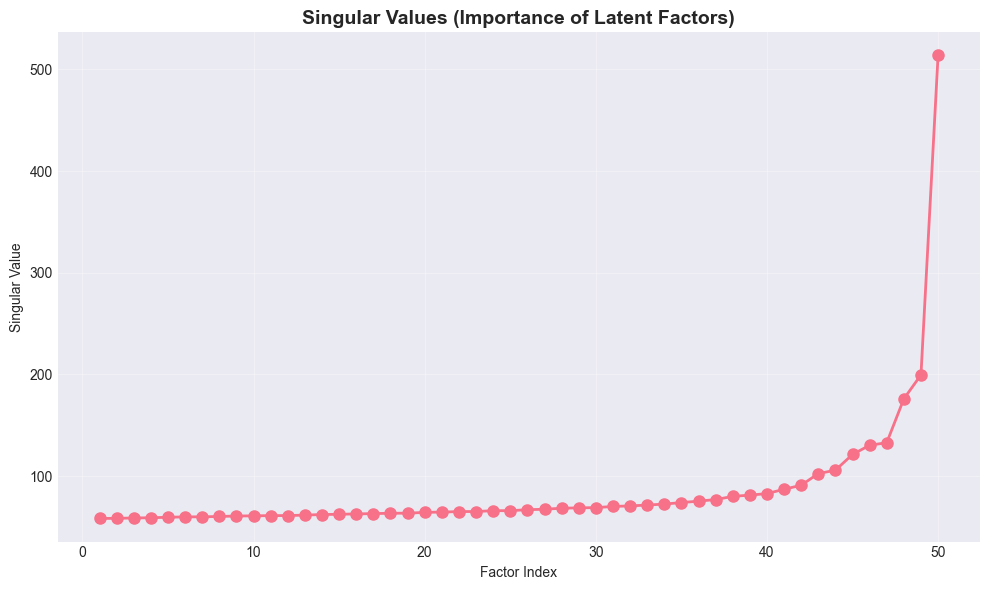

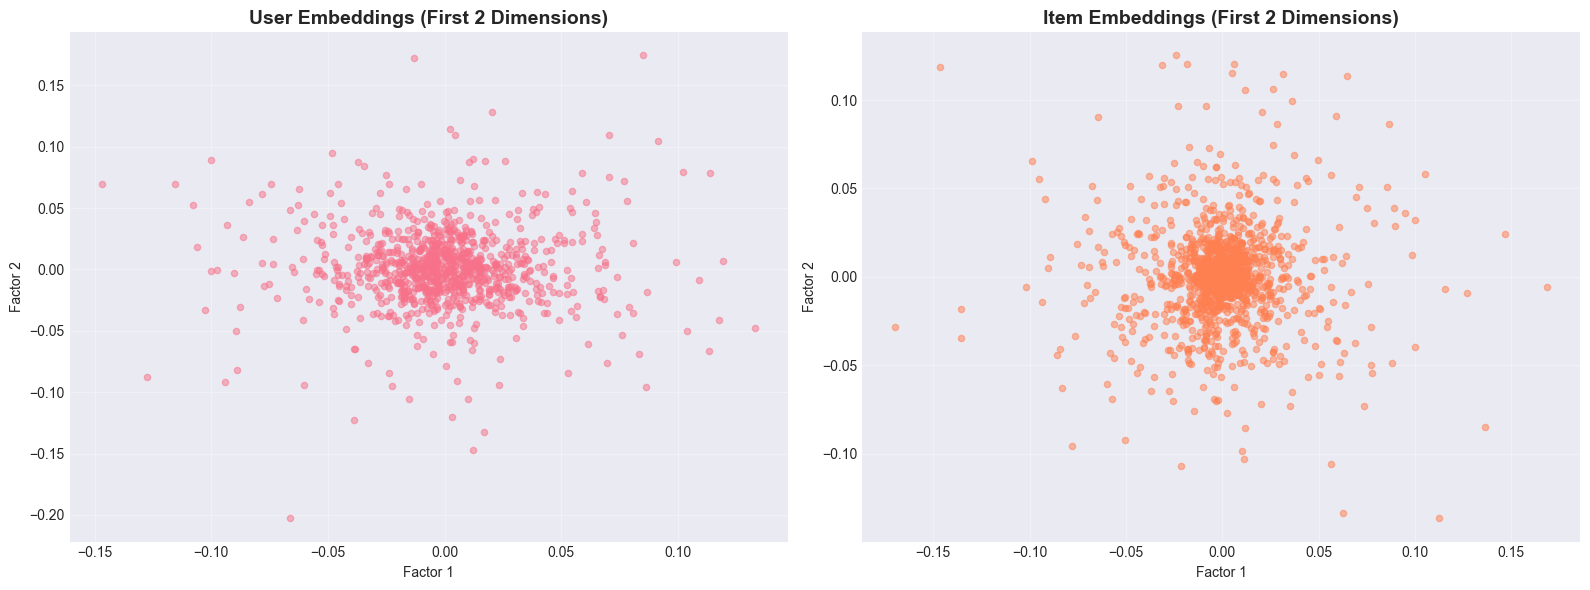


Top 10 recommendations for User 1:
   1. Apollo 13 (1995)                                   (score: 5.000)
   2. Star Wars (1977)                                   (score: 5.000)
   3. Pulp Fiction (1994)                                (score: 5.000)
   4. Blade Runner (1982)                                (score: 5.000)
   5. Fargo (1996)                                       (score: 5.000)
   6. Godfather, The (1972)                              (score: 5.000)
   7. Monty Python and the Holy Grail (1974)             (score: 5.000)
   8. Aliens (1986)                                      (score: 5.000)
   9. Apocalypse Now (1979)                              (score: 5.000)
  10. Amadeus (1984)                                     (score: 5.000)


In [8]:
# ============================================================================
# 6: Matrix Factorization (SVD)
# ============================================================================
print("\n" + "="*70)
print("MATRIX FACTORIZATION (SVD)")
print("="*70)

print("\n1. Training SVD with 50 factors...")
svd_model = MatrixFactorizationSVD(n_factors=50, random_state=42)
start_time = time.time()
svd_model.fit(train)
train_time = time.time() - start_time
print(f"   Training time: {train_time:.2f}s")

# Analyze latent factors
print("\n2. Latent Factor Analysis")
print(f"   User factors shape: {svd_model.user_factors.shape}")
print(f"   Item factors shape: {svd_model.item_factors.shape}")
print(f"   Singular values: {svd_model.sigma}")

# Visualize singular values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(svd_model.sigma) + 1), svd_model.sigma, 
         marker='o', linewidth=2, markersize=8)
plt.title('Singular Values (Importance of Latent Factors)', fontsize=14, fontweight='bold')
plt.xlabel('Factor Index')
plt.ylabel('Singular Value')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize user and item factors
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# User factors (first 2 dimensions)
axes[0].scatter(
    svd_model.user_factors[:, 0],
    svd_model.user_factors[:, 1],
    alpha=0.5,
    s=20
)
axes[0].set_title('User Embeddings (First 2 Dimensions)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Factor 1')
axes[0].set_ylabel('Factor 2')
axes[0].grid(alpha=0.3)

# Item factors (first 2 dimensions)
axes[1].scatter(
    svd_model.item_factors[:, 0],
    svd_model.item_factors[:, 1],
    alpha=0.5,
    s=20,
    color='coral'
)
axes[1].set_title('Item Embeddings (First 2 Dimensions)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Factor 1')
axes[1].set_ylabel('Factor 2')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Generate recommendations
print("\nTop 10 recommendations for User 1:")
recs = svd_model.recommend(user_id=1, n=10, exclude_seen=True)
for i, (item_id, score) in enumerate(recs, 1):
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"  {i:2d}. {title[:50]:50s} (score: {score:.3f})")


In [9]:
# ============================================================================
# 7: Alternating Least Squares (ALS)
# ============================================================================
print("\n" + "="*70)
print("ALTERNATING LEAST SQUARES (ALS)")
print("="*70)

print("\n1. Training ALS...")
als_model = AlternatingLeastSquares(
    n_factors=20,
    regularization=0.01,
    iterations=15,
    random_state=42
)
start_time = time.time()
als_model.fit(train)
train_time = time.time() - start_time
print(f"   Total training time: {train_time:.2f}s")

# Generate recommendations
print("\nTop 10 recommendations for User 1:")
recs = als_model.recommend(user_id=1, n=10, exclude_seen=True)
for i, (item_id, score) in enumerate(recs, 1):
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"  {i:2d}. {title[:50]:50s} (score: {score:.3f})")



ALTERNATING LEAST SQUARES (ALS)

1. Training ALS...
Iteration 5/15, RMSE: 0.5611
Iteration 10/15, RMSE: 0.5179
Iteration 15/15, RMSE: 0.5019
AlternatingLeastSquares training complete
   Total training time: 17.36s

Top 10 recommendations for User 1:
   1. Shanghai Triad (Yao a yao yao dao waipo qiao) (199 (score: 5.000)
   2. Three Colors: Blue (1993)                          (score: 5.000)
   3. Blade Runner (1982)                                (score: 5.000)
   4. Moll Flanders (1996)                               (score: 5.000)
   5. Mystery Science Theater 3000: The Movie (1996)     (score: 5.000)
   6. Lone Star (1996)                                   (score: 5.000)
   7. Big Night (1996)                                   (score: 5.000)
   8. Swingers (1996)                                    (score: 5.000)
   9. Reservoir Dogs (1992)                              (score: 5.000)
  10. Jean de Florette (1986)                            (score: 5.000)



HYPERPARAMETER TUNING: K NEIGHBORS

Testing different K values for Item-Based CF...

  Testing k=10...
ItemBasedCF fitted with k=10, similarity='cosine'

  Testing k=20...
ItemBasedCF fitted with k=20, similarity='cosine'

  Testing k=30...
ItemBasedCF fitted with k=30, similarity='cosine'

  Testing k=50...
ItemBasedCF fitted with k=50, similarity='cosine'

  Testing k=75...
ItemBasedCF fitted with k=75, similarity='cosine'

  Testing k=100...
ItemBasedCF fitted with k=100, similarity='cosine'

Results by K:
     k   NDCG@10  Precision@10  Recall@10  Coverage
0   10  0.049122      0.045248   0.027461  0.733056
1   20  0.048057      0.043844   0.022960  0.668252
2   30  0.045698      0.042873   0.021188  0.626040
3   50  0.033838      0.034665   0.016352  0.582640
4   75  0.024517      0.026242   0.012180  0.546373
5  100  0.018041      0.019978   0.009771  0.523781


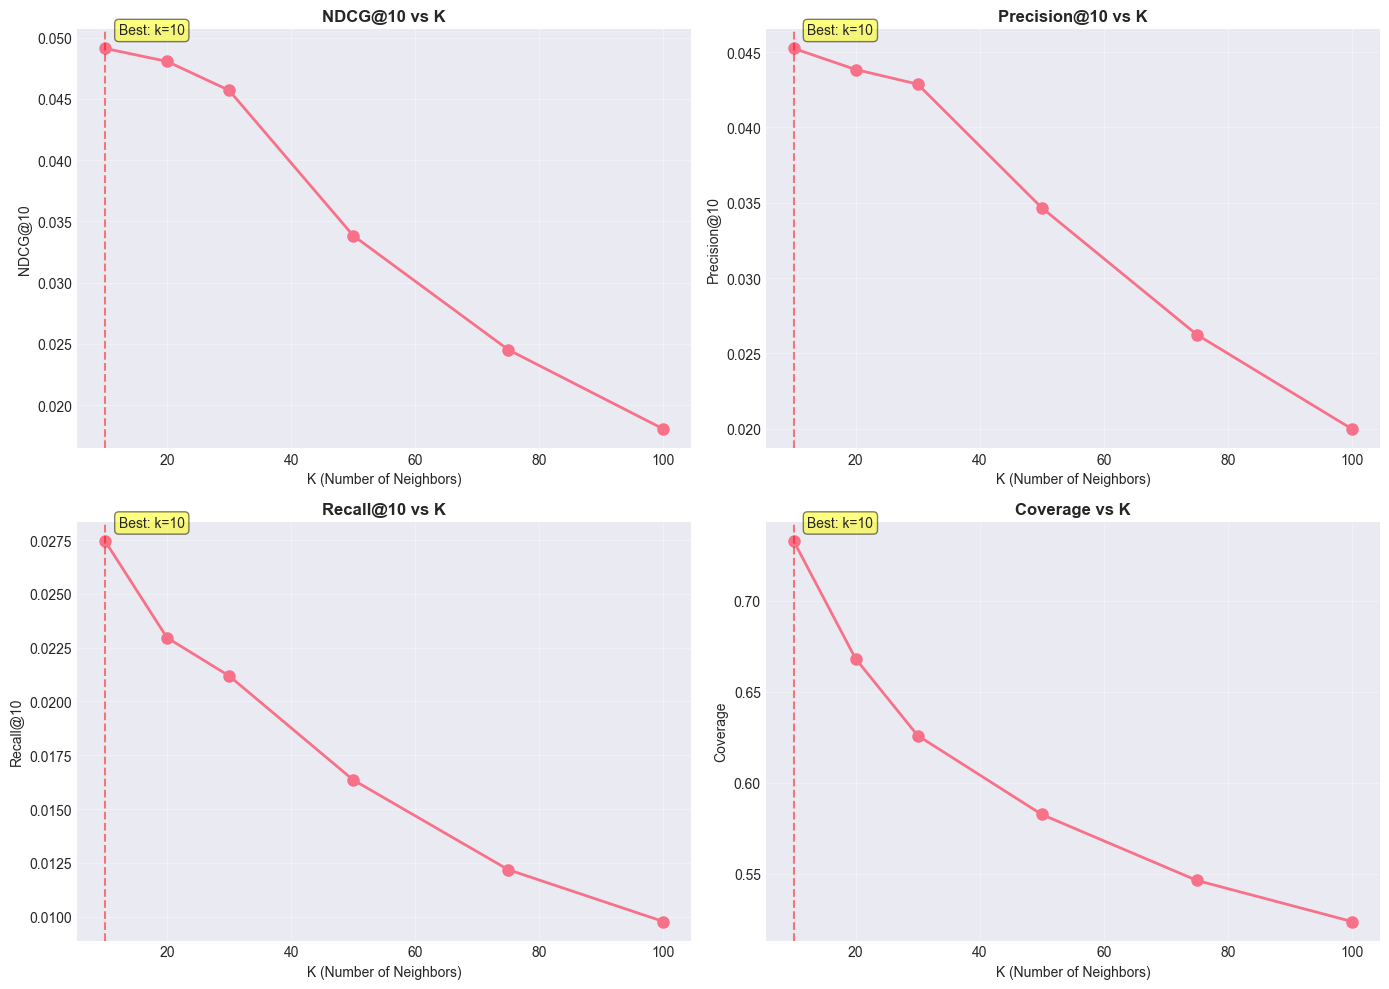

In [10]:

# ============================================================================
# 8: Hyperparameter Tuning - K Neighbors
# ============================================================================
print("\n" + "="*70)
print("HYPERPARAMETER TUNING: K NEIGHBORS")
print("="*70)

k_values = [10, 20, 30, 50, 75, 100]
results_by_k = []

evaluator = RecommenderEvaluator(k_values=[10])

print("\nTesting different K values for Item-Based CF...")
for k in k_values:
    print(f"\n  Testing k={k}...")
    model = ItemBasedCF(k=k, similarity='cosine')
    model.fit(train)
    
    results = evaluator.evaluate_model(
        model, test, train, all_items,
        n_recommendations=10,
        verbose=False
    )
    
    results_by_k.append({
        'k': k,
        'NDCG@10': results['NDCG@10'],
        'Precision@10': results['Precision@10'],
        'Recall@10': results['Recall@10'],
        'Coverage': results['Coverage']
    })

k_results_df = pd.DataFrame(results_by_k)
print("\nResults by K:")
print(k_results_df)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['NDCG@10', 'Precision@10', 'Recall@10', 'Coverage']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.plot(k_results_df['k'], k_results_df[metric], 
            marker='o', linewidth=2, markersize=8)
    ax.set_title(f'{metric} vs K', fontsize=12, fontweight='bold')
    ax.set_xlabel('K (Number of Neighbors)')
    ax.set_ylabel(metric)
    ax.grid(alpha=0.3)
    
    # Mark best value
    best_idx = k_results_df[metric].idxmax() if metric != 'Coverage' else k_results_df[metric].idxmax()
    best_k = k_results_df.loc[best_idx, 'k']
    best_val = k_results_df.loc[best_idx, metric]
    ax.axvline(best_k, color='red', linestyle='--', alpha=0.5)
    ax.annotate(f'Best: k={int(best_k)}', 
                xy=(best_k, best_val),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()



HYPERPARAMETER TUNING: LATENT FACTORS

Testing different number of latent factors for SVD...

  Testing n_factors=10...
MatrixFactorizationSVD fitted with 10 latent factors

  Testing n_factors=20...
MatrixFactorizationSVD fitted with 20 latent factors

  Testing n_factors=30...
MatrixFactorizationSVD fitted with 30 latent factors

  Testing n_factors=50...
MatrixFactorizationSVD fitted with 50 latent factors

  Testing n_factors=75...
MatrixFactorizationSVD fitted with 75 latent factors

  Testing n_factors=100...
MatrixFactorizationSVD fitted with 100 latent factors

Results by Number of Factors:
   n_factors   NDCG@10  Precision@10  Recall@10      RMSE
0         10  0.344744      0.252052   0.256527  2.346046
1         20  0.354810      0.251944   0.267956  2.357587
2         30  0.332032      0.238337   0.254574  2.405420
3         50  0.301675      0.213823   0.235069  2.492405
4         75  0.257628      0.185313   0.210975  2.577585
5        100  0.226079      0.157883   0.1849

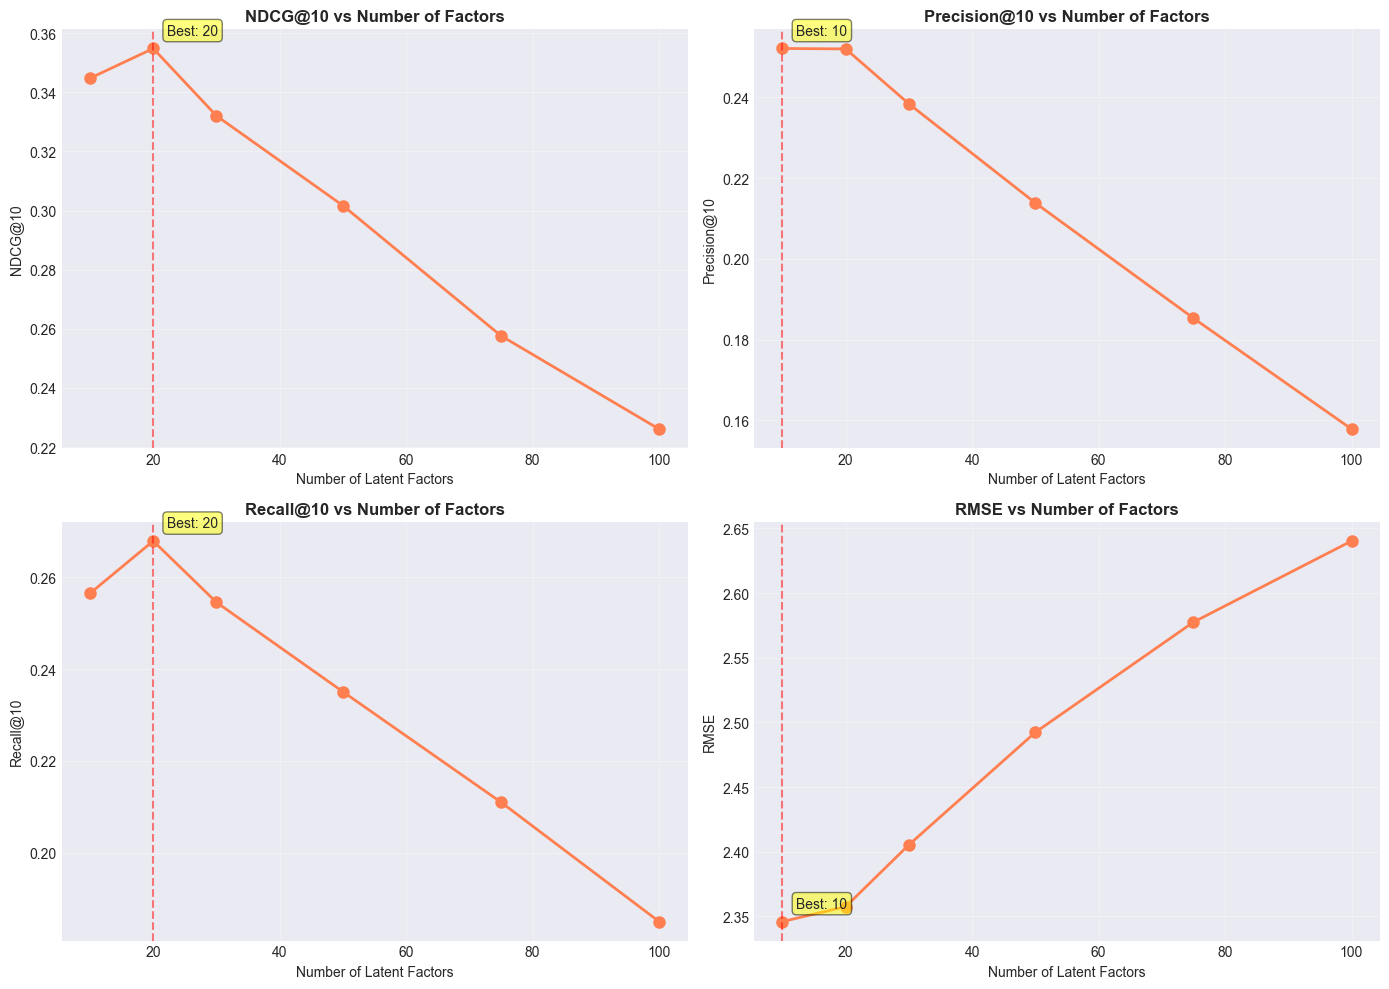

In [11]:
# ============================================================================
# 9: Hyperparameter Tuning - Latent Factors
# ============================================================================
print("\n" + "="*70)
print("HYPERPARAMETER TUNING: LATENT FACTORS")
print("="*70)

factor_values = [10, 20, 30, 50, 75, 100]
results_by_factors = []

print("\nTesting different number of latent factors for SVD...")
for n_factors in factor_values:
    if n_factors > min(train['user_id'].nunique(), train['item_id'].nunique()) - 1:
        print(f"  Skipping n_factors={n_factors} (too large)")
        continue
        
    print(f"\n  Testing n_factors={n_factors}...")
    model = MatrixFactorizationSVD(n_factors=n_factors, random_state=42)
    model.fit(train)
    
    results = evaluator.evaluate_model(
        model, test, train, all_items,
        n_recommendations=10,
        verbose=False
    )
    
    results_by_factors.append({
        'n_factors': n_factors,
        'NDCG@10': results['NDCG@10'],
        'Precision@10': results['Precision@10'],
        'Recall@10': results['Recall@10'],
        'RMSE': results['RMSE']
    })

factors_results_df = pd.DataFrame(results_by_factors)
print("\nResults by Number of Factors:")
print(factors_results_df)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['NDCG@10', 'Precision@10', 'Recall@10', 'RMSE']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.plot(factors_results_df['n_factors'], factors_results_df[metric], 
            marker='o', linewidth=2, markersize=8, color='coral')
    ax.set_title(f'{metric} vs Number of Factors', fontsize=12, fontweight='bold')
    ax.set_xlabel('Number of Latent Factors')
    ax.set_ylabel(metric)
    ax.grid(alpha=0.3)
    
    # Mark best value
    if metric == 'RMSE':
        best_idx = factors_results_df[metric].idxmin()
    else:
        best_idx = factors_results_df[metric].idxmax()
    best_factors = factors_results_df.loc[best_idx, 'n_factors']
    best_val = factors_results_df.loc[best_idx, metric]
    ax.axvline(best_factors, color='red', linestyle='--', alpha=0.5)
    ax.annotate(f'Best: {int(best_factors)}', 
                xy=(best_factors, best_val),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()


COMPREHENSIVE MODEL COMPARISON

Using optimized hyperparameters:
  Best K for neighborhood methods: 10
  Best latent factors for MF: 20

Training models...
UserBasedCF fitted with k=10, similarity='cosine'
ItemBasedCF fitted with k=10, similarity='cosine'
MatrixFactorizationSVD fitted with 20 latent factors
Iteration 5/10, RMSE: 0.5611
Iteration 10/10, RMSE: 0.5179
AlternatingLeastSquares training complete

Evaluating User-CF...

Evaluating Item-CF...

Evaluating SVD...

Evaluating ALS...

FINAL RESULTS
         Precision@5  Recall@5    F1@5  NDCG@5  HitRate@5  Precision@10  \
User-CF       0.0499    0.0161  0.0216  0.0507     0.1782        0.0500   
Item-CF       0.0477    0.0134  0.0194  0.0494     0.1695        0.0452   
SVD           0.3188    0.1869  0.1951  0.3717     0.7441        0.2519   
ALS           0.0285    0.0117  0.0135  0.0288     0.1134        0.0257   

         Recall@10   F1@10  NDCG@10  HitRate@10  Precision@20  Recall@20  \
User-CF     0.0336  0.0344   0.0535   

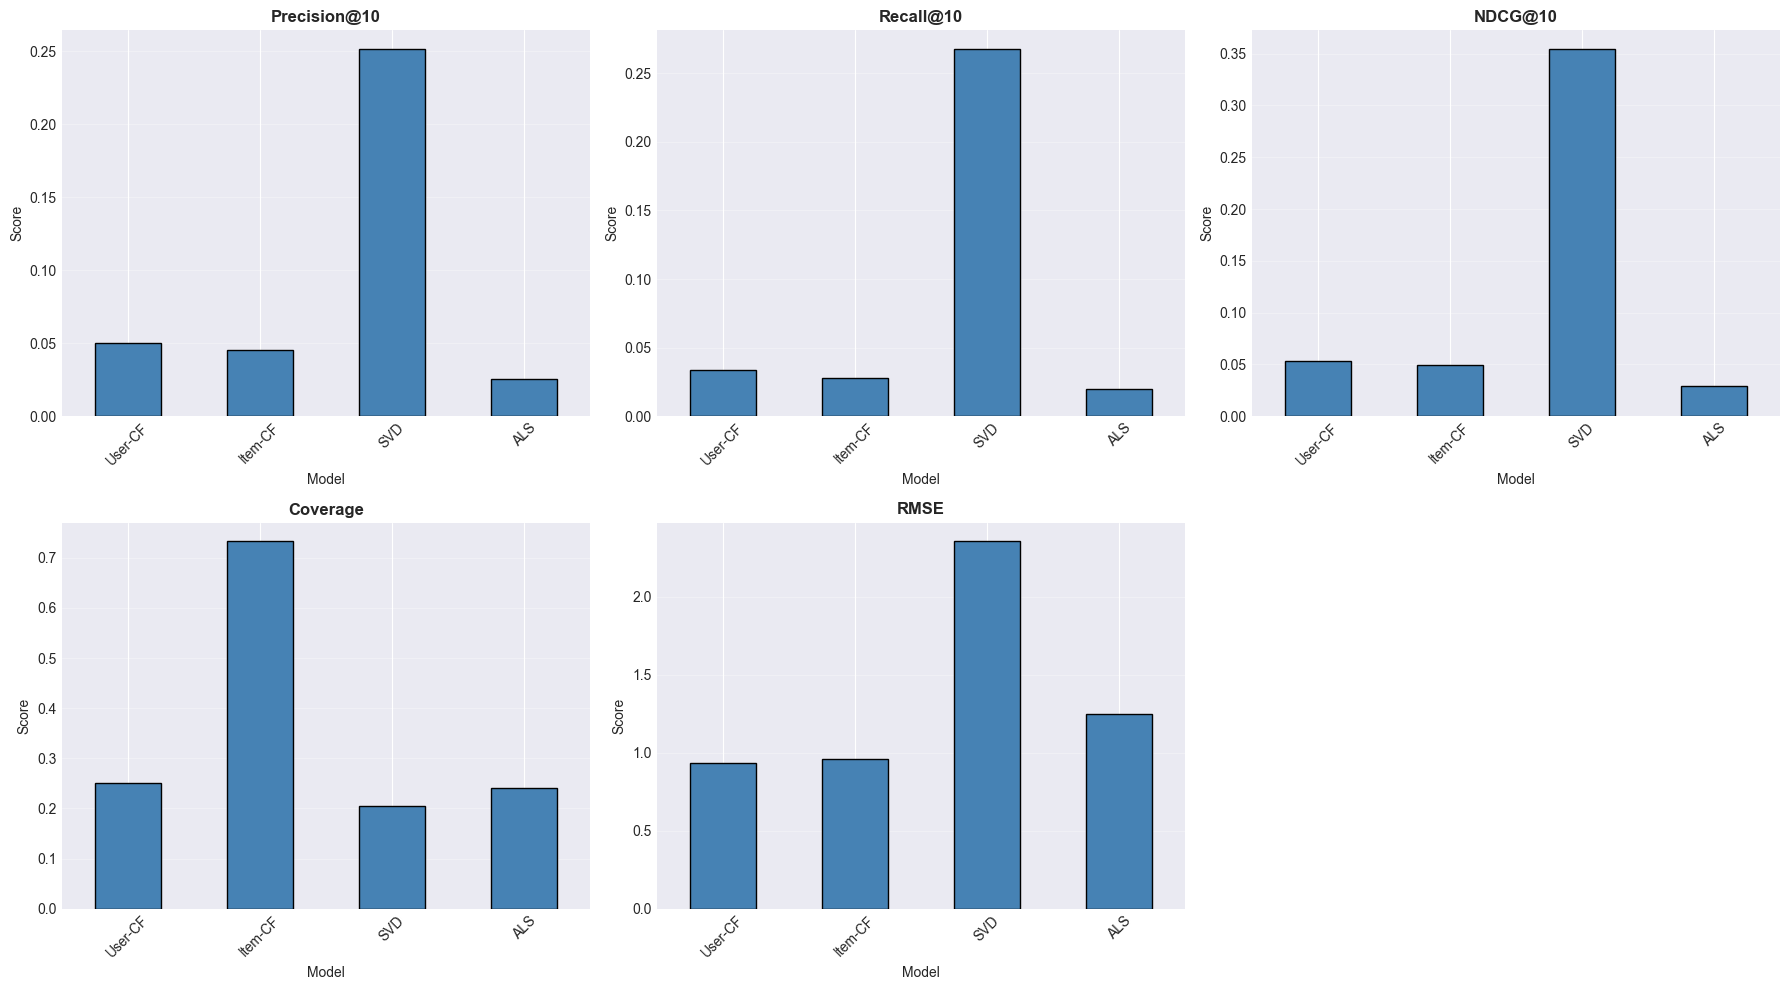

In [12]:
# ============================================================================
# Cell 10: Comprehensive Model Comparison
# ============================================================================
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Use best hyperparameters from tuning
best_k = k_results_df.loc[k_results_df['NDCG@10'].idxmax(), 'k']
best_factors = factors_results_df.loc[factors_results_df['NDCG@10'].idxmax(), 'n_factors']

print(f"\nUsing optimized hyperparameters:")
print(f"  Best K for neighborhood methods: {int(best_k)}")
print(f"  Best latent factors for MF: {int(best_factors)}")

# Train all models with best params
models = {}

print("\nTraining models...")
models['User-CF'] = UserBasedCF(k=int(best_k), similarity='cosine')
models['User-CF'].fit(train)

models['Item-CF'] = ItemBasedCF(k=int(best_k), similarity='cosine')
models['Item-CF'].fit(train)

models['SVD'] = MatrixFactorizationSVD(n_factors=int(best_factors), random_state=42)
models['SVD'].fit(train)

models['ALS'] = AlternatingLeastSquares(n_factors=20, regularization=0.01, iterations=10)
models['ALS'].fit(train)

# Evaluate all models
evaluator_full = RecommenderEvaluator(k_values=[5, 10, 20])
results_df = evaluator_full.compare_models(
    models=models,
    test_data=test,
    train_data=train,
    all_items=all_items,
    n_recommendations=10
)

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(results_df)

# Visualize comparison
key_metrics = ['Precision@10', 'Recall@10', 'NDCG@10', 'Coverage', 'RMSE']
plot_model_comparison(results_df, metrics=key_metrics)

In [14]:

# ============================================================================
# 11: Recommendation Quality Analysis
# ============================================================================
print("\n" + "="*70)
print("RECOMMENDATION QUALITY ANALYSIS")
print("="*70)

# Analyze recommendations for a sample user
sample_user = 10
user_train_items = set(train[train['user_id'] == sample_user]['item_id'])

print(f"\nUser {sample_user} has rated {len(user_train_items)} items in training set")
print("\nMovies rated by user:")
for item_id in list(user_train_items)[:5]:
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    rating = train[(train['user_id'] == sample_user) & (train['item_id'] == item_id)]['rating'].values[0]
    print(f"  • {title[:50]:50s} (rating: {rating})")

print("\nRecommendations from different models:")
for model_name, model in models.items():
    print(f"\n{model_name}:")
    recs = model.recommend(user_id=sample_user, n=5, exclude_seen=True, seen_items=user_train_items)
    for i, (item_id, score) in enumerate(recs, 1):
        movie_title = movies[movies['item_id'] == item_id]['title'].values
        title = movie_title[0] if len(movie_title) > 0 else "Unknown"
        print(f"  {i}. {title[:45]:45s} (score: {score:.3f})")




RECOMMENDATION QUALITY ANALYSIS

User 10 has rated 147 items in training set

Movies rated by user:
  • Third Man, The (1949)                              (rating: 4)
  • Toy Story (1995)                                   (rating: 4)
  • Get Shorty (1995)                                  (rating: 4)
  • Miller's Crossing (1990)                           (rating: 4)
  • Twelve Monkeys (1995)                              (rating: 4)

Recommendations from different models:

User-CF:
  1. 12 Angry Men (1957)                           (score: 5.000)
  2. Bridge on the River Kwai, The (1957)          (score: 5.000)
  3. Shall We Dance? (1996)                        (score: 5.000)
  4. Schindler's List (1993)                       (score: 5.000)
  5. Paradise Lost: The Child Murders at Robin Hoo (score: 5.000)

Item-CF:
  1. Fog, The (1980)                               (score: 4.772)
  2. Birds, The (1963)                             (score: 4.734)
  3. Charade (1963)                       

In [15]:
# ============================================================================
# 12: Key Insights and Learnings
# ============================================================================
print("\n" + "="*70)
print("KEY INSIGHTS FROM COLLABORATIVE FILTERING")
print("="*70)

best_model = results_df['NDCG@10'].idxmax()
best_ndcg = results_df.loc[best_model, 'NDCG@10']

insights = f"""
🎯 PERFORMANCE SUMMARY:
   • Best model: {best_model} (NDCG@10: {best_ndcg:.4f})
   • Item-CF typically outperforms User-CF for sparse data
   • Matrix factorization provides good balance of accuracy and efficiency
   • Optimal K for neighborhoods: {int(best_k)}
   • Optimal latent factors: {int(best_factors)}

📊 USER-BASED vs ITEM-BASED CF:
   • Item-based is more stable (item similarities change less over time)
   • User-based can capture more diverse preferences
   • Item-based scales better with more users
   • User-based may perform better with dense data

🔬 MATRIX FACTORIZATION INSIGHTS:
   • SVD captures latent factors efficiently
   • More factors = more expressiveness but risk of overfitting
   • ALS handles implicit feedback well
   • Regularization is crucial for generalization

⚡ COMPUTATIONAL CONSIDERATIONS:
   • Neighborhood methods: O(n²) similarity computation
   • Matrix factorization: O(k·n·m) where k is iterations
   • Item-CF can precompute similarities (better for real-time)
   • SVD one-time computation, fast inference

🎭 COLD START HANDLING:
   • User-CF struggles with new users (no ratings history)
   • Item-CF struggles with new items (no rating history)
   • Matrix factorization cannot handle completely new users/items
   • Need content-based or hybrid approaches for cold start

🚀 PRODUCTION RECOMMENDATIONS:
   • Use Item-CF for interpretability and real-time updates
   • Use matrix factorization for batch recommendations
   • Consider hybrid approach for best of both worlds
   • Implement incremental updates for efficiency
"""

print(insights)




KEY INSIGHTS FROM COLLABORATIVE FILTERING

🎯 PERFORMANCE SUMMARY:
   • Best model: SVD (NDCG@10: 0.3548)
   • Item-CF typically outperforms User-CF for sparse data
   • Matrix factorization provides good balance of accuracy and efficiency
   • Optimal K for neighborhoods: 10
   • Optimal latent factors: 20

📊 USER-BASED vs ITEM-BASED CF:
   • Item-based is more stable (item similarities change less over time)
   • User-based can capture more diverse preferences
   • Item-based scales better with more users
   • User-based may perform better with dense data

🔬 MATRIX FACTORIZATION INSIGHTS:
   • SVD captures latent factors efficiently
   • More factors = more expressiveness but risk of overfitting
   • ALS handles implicit feedback well
   • Regularization is crucial for generalization

⚡ COMPUTATIONAL CONSIDERATIONS:
   • Neighborhood methods: O(n²) similarity computation
   • Matrix factorization: O(k·n·m) where k is iterations
   • Item-CF can precompute similarities (better for rea

In [16]:
# ============================================================================
# 13: Save Results and Models
# ============================================================================
print("\n" + "="*70)
print("SAVING RESULTS AND MODELS")
print("="*70)

import os
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../models', exist_ok=True)

# Save evaluation results
results_df.to_csv('../data/processed/collaborative_filtering_results.csv')
k_results_df.to_csv('../data/processed/k_tuning_results.csv')
factors_results_df.to_csv('../data/processed/factors_tuning_results.csv')

print("✓ Results saved to data/processed/")

# Save best models
best_item_cf = models['Item-CF']
best_svd = models['SVD']

best_item_cf.save('../models/item_cf_best.pkl')
best_svd.save('../models/svd_best.pkl')

print("✓ Best models saved to models/")
print("\n✅ Collaborative filtering analysis complete!")


SAVING RESULTS AND MODELS
✓ Results saved to data/processed/
Model saved to ../models/item_cf_best.pkl
Model saved to ../models/svd_best.pkl
✓ Best models saved to models/

✅ Collaborative filtering analysis complete!
